In [1]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.models as models


from torchvision import models
import torchvision.transforms as T
from torchvision.datasets import CIFAR10

import torchutils as tu

import matplotlib.pyplot as plt
import numpy as np
from torch.utils.tensorboard import SummaryWriter

In [2]:
DEVICE = 'cpu'

In [3]:
Ya_transforms = T.Compose(
    [
        T.Resize((32, 32)),
        T.ToTensor(),
        T.RandomChoice(
            [
                T.ColorJitter(),
                T.RandomHorizontalFlip(),
                T.GaussianBlur(3),
                T.RandomSolarize(.6)
            ]
        )
    ]
)

Yb_transforms = T.Compose(
    [
        T.Resize((32, 32)),
        T.ToTensor(),
        T.RandomChoice(
            [
                T.ColorJitter(),
                T.RandomHorizontalFlip(),
                T.GaussianBlur(9),
                T.RandomSolarize(.3)
            ]
        )
    ]
)

In [4]:
A_dataset = CIFAR10(
    'data',
    train = 'True',
    download = True,
    transform=Ya_transforms
)


B_dataset = CIFAR10(
    'data',
    train = 'True',
    download = True,
    transform=Yb_transforms
)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
BATCH_SIZE=256
A_loader = DataLoader(A_dataset, batch_size=BATCH_SIZE)
B_loader = DataLoader(B_dataset, batch_size=BATCH_SIZE)

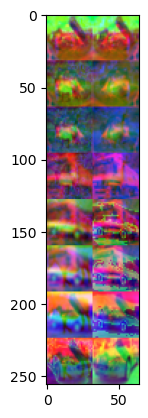

In [7]:
n = 8
a_example = next(iter(A_loader))[0][:n].view(3, 32*n, 32).permute(1, 2, 0)
b_example = next(iter(B_loader))[0][:n].view(3, 32*n, 32).permute(1, 2, 0)

plt.imshow(torch.cat([a_example, b_example], 1))

In [8]:
# class Encoder(nn.Module):
#     def __init__(self) -> None:
#         super().__init__()

#         self.conv1 = nn.Sequential(
#             nn.Conv2d(1, 32, 4, 1),
#             nn.Dropout(),
#             nn.ReLU(),
#             nn.BatchNorm2d(32)
#         )

#         self.conv2 = nn.Sequential(
#             nn.Conv2d(32, 16, 6, 2),
#             nn.Dropout(),
#             nn.ReLU(),
#             nn.BatchNorm2d(16)
#         )

#         self.linear = nn.Sequential(
#             nn.LazyLinear(16)
#         )

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.conv2(x)
#         x = x.view(x.size(0), -1)
#         out = self.linear(x)
#         return out


In [9]:
resnet = models.resnet18(weights=models.ResNet18_Weights)
encoder = torch.nn.Sequential(*(list(resnet.children())[:-1]))
for i in encoder.parameters():
    i.requires_grad = False

/Users/paveldumin/miniforge3/envs/pt/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
class Projector(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.proj = nn.Sequential(
            nn.Linear(in_features=512, out_features=32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )

    def forward(self, x):
        return self.proj(x.view(x.size(0), -1))

In [26]:
class F_theta(nn.Module):
    def __init__(self, encoder: torch.nn.Module) -> None:
        super().__init__()

        self.encoder = encoder
        self.projector = Projector()

    def forward(self, x):
        return self.projector(self.encoder(x))
model = F_theta(encoder)

In [27]:
out = encoder(torch.randn(BATCH_SIZE, 3, 32, 32))
print(out.view(out.shape[0], -1).shape)

torch.Size([256, 512])


In [29]:
tu.get_model_summary(
    model.to(DEVICE), 
    x=torch.randn(BATCH_SIZE, 3, 32, 32, device=DEVICE)
    )

Layer                                          Kernel             Output          Params           FLOPs
0_encoder.Conv2d_0                           [3, 64, 7, 7]   [256, 64, 16, 16]       9,408   616,562,688
1_encoder.BatchNorm2d_1                               [64]   [256, 64, 16, 16]         128    16,777,216
2_encoder.ReLU_2                                         -   [256, 64, 16, 16]           0             0
3_encoder.MaxPool2d_3                                    -     [256, 64, 8, 8]           0             0
4_encoder.4.0.Conv2d_conv1                  [64, 64, 3, 3]     [256, 64, 8, 8]      36,864   603,979,776
5_encoder.4.0.BatchNorm2d_bn1                         [64]     [256, 64, 8, 8]         128     4,194,304
6_encoder.4.0.ReLU_relu                                  -     [256, 64, 8, 8]           0             0
7_encoder.4.0.Conv2d_conv2                  [64, 64, 3, 3]     [256, 64, 8, 8]      36,864   603,979,776
8_encoder.4.0.BatchNorm2d_bn2                         [

In [30]:
def normalize(x):
    return (x - x.mean(0)) / x.std(0)

In [31]:
optimizer = torch.optim.Adam(model.parameters())
writer = SummaryWriter()

In [32]:
model.train()

losses = []

for epoch in range(10):
    batch_losses = []
    for batch_idx, (x_a, x_b) in enumerate(zip(A_loader, B_loader)):
        out_a = model(x_a[0].to(DEVICE)).view(x_a[0].size(0), -1)
        # print(out_a.shape)
        out_b = model(x_b[0].to(DEVICE)).view(x_b[0].size(0), -1)

        out_a_normed = normalize(out_a)
        out_b_normed = normalize(out_b)

        c = torch.matmul(out_a_normed.T, out_b_normed) / BATCH_SIZE

        c_diff = (c - torch.eye(c.shape[0]).to(DEVICE)).pow(2)

        c_diff.flatten()[:-1].view(c_diff.size(0) - 1, c_diff.size(0)+1)[:, 1:].mul_(.5)

        loss = c_diff.sum()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())
        writer.add_scalar('Loss/train', batch_losses[-1], batch_idx)
    losses.append(np.mean(batch_losses))

    print(f'Epoch n: {epoch}, loss: {losses[-1]}')

torch.Size([256, 16])
torch.Size([256, 16])


KeyboardInterrupt: 